# Model lowercase characters and score NIST dataset
    - Create a model only with lowercase charactes of the new character database. 
    - Evaluate it in a test partition
    - Use the previous trained model to score the lowercase characters of NIST test database

In [1]:
path = '/home/jorge/data/tesis/handwriting/databases/unipen/'

import numpy as np
import pandas as pd
#import cv2

from scipy.misc import imresize, imrotate, imsave 


import matplotlib.pyplot as plt

# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'              # use grayscale output color heatmap


In [2]:
#
#Select a subset of characters
#
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing

def prepare_data_char_subset(X, y, char_select):
    '''
    Definition: Create train test data to model it
        - Select cases
        - shuffle
        - separate train test
        - encode target to dummy vars
    Parameters:
        X: images[n_images, x_size, y_size]
        y: characters[n_images, 1]
        char_select: list of characters selected
        augmentation_fuction
    
    usage:
        prepare_data_char_subset(X, y, set(['1','0']), augmentation_fuction = lambda: augmentate01(param1, param2=p2) )
        
    return:
        X_train, y_train, X_test, y_test, labels_dictionary
    '''
    #Select cases
    X_select = []
    y_select = []
    for row in xrange(X.shape[0]):
        if y[row] in set(char_select):
            X_select += [X[row,:,:]]
            y_select += y[row]
    X_select = np.array(X_select, dtype = np.float16)
    y_select = np.array(y_select)
    print 'Shape of selected cases:', X_select.shape, y_select.shape
    
    
    #Shuffle
    X_select, y_select = shuffle(X_select, y_select, random_state=0)
    
    #Reescale
    X_select = X_select/255.
    
    #Recode target
    decode_target={}
    encode_target={}
    for i,c in enumerate(char_select):
        decode_target[i] = c 
        encode_target[c] = i
    y_select = np.array([encode_target[y] for y in y_select])
    

    #Separate train test
    X_train, X_test, y_train_ini, y_test_ini = train_test_split(X_select, y_select, test_size=0.20, random_state=42)
    X_train = np.reshape(X_train,  (X_train.shape[0],1,X_train.shape[1],X_train.shape[2]))
    X_test = np.reshape(X_test,  (X_test.shape[0],1,X_test.shape[1],X_test.shape[2]))
    
    print 'Train shape: ',X_train.shape, y_train_ini.shape
    print 'Test shape: ',X_test.shape, y_test_ini.shape
    print 'Num classes: ', len(set(y_train_ini))
    print 'Classes:', set(y_train_ini)
    
    return X_train, y_train_ini, X_test, y_test_ini, decode_target


In [3]:
#Load data from hdf5
import h5py

hdf5_f = h5py.File(path + "characters_base_64x64.hdf5", mode='r')

X = hdf5_f["X_curated_chars"]
y = hdf5_f["y_curated_chars"]
y_chars = np.array(y)
print(X.shape, y.shape)

char_select = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
               'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

X_train_l, y_train_l, X_test_l, y_test_l, decode_target_l = prepare_data_char_subset(X, y, char_select)
print(X_train_l.shape, X_test_l.shape)

hdf5_f.close()

((46102, 64, 64), (46102,))
Shape of selected cases: (29845, 64, 64) (29845,)
Train shape:  (23876, 1, 64, 64) (23876,)
Test shape:  (5969, 1, 64, 64) (5969,)
Num classes:  26
Classes: set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])
((23876, 1, 64, 64), (5969, 1, 64, 64))


In [4]:
print(decode_target_l)
print(X_train_l[0,:,32,:])
print(y_test_l[:5])

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}
[[ 0.          0.          0.          0.          0.          0.          0.
   1.          1.          0.79589844  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          1.          1.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.        ]]
[ 8  4 17 17 17]


## Model creation

In [5]:
#
#first model
#

from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import SGD

print('Build model 1...')
input_images = Input(shape=(1, 64, 64))

c11 = Convolution2D(64, 3, 3, border_mode='same', activation='relu')(input_images)
c12 = Convolution2D(64, 3, 3, border_mode='same', activation='relu')(c11)
c1_mp = MaxPooling2D((2, 2))(c12)

c21 = Convolution2D(128, 3, 3, border_mode='same', activation='relu')(c1_mp)
c22 = Convolution2D(128, 3, 3, border_mode='same', activation='relu')(c21)
c2_mp = MaxPooling2D((2, 2))(c22)

c31 = Convolution2D(256, 3, 3, border_mode='same', activation='relu')(c2_mp)
c32 = Convolution2D(256, 3, 3, border_mode='same', activation='relu')(c31)
c33 = Convolution2D(256, 3, 3, border_mode='same', activation='relu')(c32)
c3_mp = MaxPooling2D((2, 2))(c33)

conv_out = Flatten()(c3_mp)

dense1 = Dense(1024, activation='relu')(conv_out)
after_dp1 = Dropout(0.5)(dense1)

dense2 = Dense(1024, activation='relu')(after_dp1)
after_dp2 = Dropout(0.5)(dense2)

output = Dense(26, activation='softmax')(after_dp2)

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN Black (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:599: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


Build model 1...


In [6]:
#Data augmentation in keras
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range = 15,       # 15º of random rotation
    width_shift_range = 0.20,  # 20% of random translation width
    height_shift_range = 0.20, # 20% of random translation height
    shear_range = 0.15,        # 5º of shear
    zoom_range = 0.20)         # +- 20% of zoom 



In [8]:
# Create the model
model_l = Model(input=input_images, output=output)

#Fit model  on batches with real-time data augmentation:
sgd = SGD(lr=0.01, decay=0.001, momentum=0.9, nesterov=True)
model_l.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

hist_l_1 = model_l.fit_generator(datagen.flow(X_train_l, y_train_l, batch_size=128),
                    samples_per_epoch=len(X_train_l), nb_epoch=100, 
                    validation_data=(X_test_l, y_test_l))

print 'Done!'

Epoch 1/100
23876/23876 [==============================] - 82s - loss: 2.9439 - acc: 0.1551 - val_loss: 1.8418 - val_acc: 0.4681
Epoch 2/100
23876/23876 [==============================] - 87s - loss: 2.0718 - acc: 0.3909 - val_loss: 1.1987 - val_acc: 0.6740
Epoch 3/100
23876/23876 [==============================] - 87s - loss: 1.4779 - acc: 0.5665 - val_loss: 0.7731 - val_acc: 0.7859
Epoch 4/100
23876/23876 [==============================] - 87s - loss: 1.1737 - acc: 0.6458 - val_loss: 0.5113 - val_acc: 0.8529
Epoch 5/100
23876/23876 [==============================] - 87s - loss: 1.0030 - acc: 0.6990 - val_loss: 0.3951 - val_acc: 0.8849
Epoch 6/100
23876/23876 [==============================] - 87s - loss: 0.8909 - acc: 0.7316 - val_loss: 0.3584 - val_acc: 0.9000
Epoch 7/100
23876/23876 [==============================] - 87s - loss: 0.8081 - acc: 0.7549 - val_loss: 0.3347 - val_acc: 0.9060
Epoch 8/100
23876/23876 [==============================] - 87s - loss: 0.7377 - acc: 0.7781 - val

# Accuracy for UNIPEN lower case: 96.3%

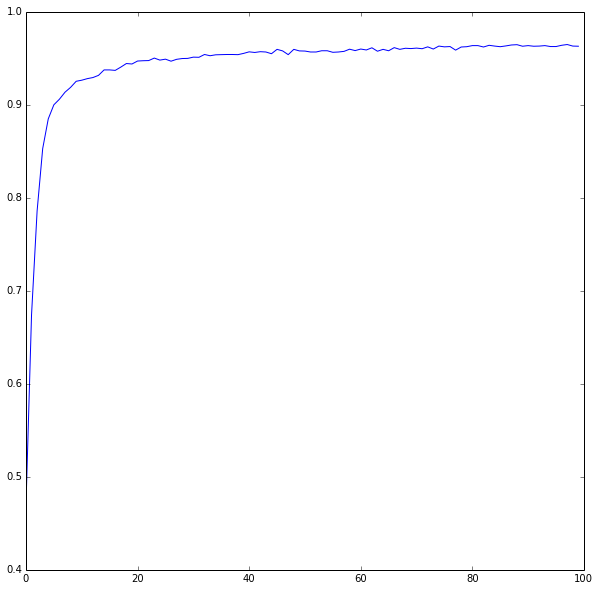

In [9]:
plt.plot(hist_l_1.history['val_acc'])

In [10]:
#Save model
path_models = '/home/jorge/data/tesis/handwriting/p01_read_character/'

model_name = 'unipen_lowercase_01'

json_string = model_l.to_json()
open(path_models + 'models/mdl_' + model_name + '.json', 'w').write(json_string)
model_l.save_weights(path_models + 'models/w_' + model_name + '.h5', overwrite=True)

# Save decode_target
import pickle
pickle.dump( decode_target_l, open( path_models + "models/unipen_decode_target_lowercase.p", "wb" ) )

# Use the previous created model to score NIST database

In [52]:
#Load model
from keras.models import model_from_json

model_name = 'unipen_lowercase_01'

model_l = model_from_json(open(path_models + 'models/mdl_' + model_name + '.json').read())
model_l.load_weights(path_models + 'models/w_' + model_name + '.h5')

# Load the dictionary back from the pickle file.
import pickle
decode_target = pickle.load( open(path_models + "models/unipen_decode_target_lowercase.p", "rb" ) )
    

In [11]:
#Read NIST dataset 

#Read NIST database
path_NIST='/home/jorge/data/tesis/handwriting/databases/NIST/by_class/'


char_list_lo = ['61','62','63','64','65','66','67','68','69','6a','6b','6c','6d'
               ,'6e','6f','70','71','72','73','74','75','76','77','78','79','7a']


decode_lo={}
encode_lo={}
for i , c in enumerate(char_list_lo):
    char = str(unichr(int(c,16)))
    decode_lo[i] = char
    encode_lo[char] = i
print decode_lo               


{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}


In [12]:
# Generator of list of files in a folder and subfolders
import os
import shutil
import fnmatch

def gen_find(filepat,top):
    for path, dirlist, filelist in os.walk(top):
        for name in fnmatch.filter(filelist,filepat):
            yield os.path.join(path,name)

In [15]:
hsf='/hsf_4/'

#Read test dataset
X_NIST_lo=[]
y_NIST_lo=[]
for char in char_list_lo:
    letter = str(unichr(int(char,16)))
    images_list = gen_find("*.png", path_NIST+char+hsf) 
    for img_name in images_list:
        img = plt.imread(img_name)
        
        #Transform
        img = img[32:96,32:96,0]
        
        X_NIST_lo += [img]
        y_NIST_lo += [encode_lo[letter]]

X_NIST_lo = 1. - np.array(X_NIST_lo)
y_NIST_lo = np.array(y_NIST_lo)
        
print(X_NIST_lo.shape)
print(y_NIST_lo.shape)

(12000, 64, 64)
(12000,)


In [16]:
print(X_NIST_lo[0,32,:])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [17]:
y_pred = model_l.predict(X_NIST_lo.reshape((12000, 1, 64, 64)), batch_size=128)
print(y_pred.shape)


(12000, 26)


In [18]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_NIST_lo, np.argmax(y_pred, axis=1)))

0.715166666667


# Accuracy  for NIST database (2nd ed) lower case: 71.5%
    - The low score can be explained because the NIST database is binary (pixels only 0 or 1).
    - We need to train the same architecture over the NIST database in order to obtain a better comparation to others.